In [1]:
pip install keras-transformer

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras-transformer: filename=keras_transformer-0.40.0-py3-none-any.whl size=12286 sha256=090685c17e4f9d2bf064bef2a7384c3a8e1f88752ea1d0f848c02a52e5b5deec
  Stored in directory: /root/.cache/pip/wheels/f2/cb/22/75a0ad376129177f7c95c0d91331a18f5368fd657f4035ba7c
  Created wheel for keras-embed-sim: filename=keras_embed_sim-0.10.0-py3-none-any.whl size=3943 sha256=2dcbabe04a1e8be3e4c6832998a9d6a11e59f41ece0a2ad62d834695011fbb3a
  Stored in directory: /root/.cache/pip/wheels/82/32/c7/fd35d0d1b840a6c7cbd4343f808d10d0f7b87d271a4dbe796f
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4653 sha256=2e711e9adf5a9c4f4994ab6ac87d7e8e6ea

### Librerias usadas

In [2]:
import numpy as np
from keras_transformer import get_model, decode
import tensorflow as tf
import random
from google.colab import drive
import matplotlib.pyplot as plt
from pickle import load

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Carga del corpus

In [4]:
filename = '/content/drive/My Drive/Trabajo_Embermind/Ejercicio_1/Modelo_1'
dataset = load(open(filename+"/Corpus/english-spanish.pkl", 'rb'))
data_list = dataset.tolist()
len(data_list)

124325

In [5]:
final_corpus = data_list
final_corpus[0]

['go', 've']

### Creación de tokens

In [6]:
source_tokens = [] #Tokens español
target_tokens = [] #Tokens inglés
for en, es in final_corpus:
    source_tokens.append(es.split(' '))
    target_tokens.append(en.split(' '))

print(source_tokens[0])
print(target_tokens[0])

['ve']
['go']


### Función de creación de los diccionarios de tokens

In [7]:
def do_token_dict(token_list):
    #Tokens especiales que usaremos para rellenar, para identificar el inicio y el final de la frase
    token_dict = {
        "<PAD>": 0,
        "<START>":1,
        "<END>":2,
    }
    #Bucle que coge la lista de frases tokenizadas una por una y agrega los nuevos tokens al diccionario
    for tokens in token_list:
        for token in tokens:
            if token not in token_dict:
                token_dict[token] = len(token_dict)
    return token_dict

### Creación de los diccionarios usando la anterior función

#### Explicación del target_token_dict_inv: Creamos este diccionario inverso ya que el output del decoder son números que correspoden a estos tokens (texto), pero a nosotros nos interesa el texto, no los números. Creando el diccionario inverso podemos obtener las palabras que equivalen a esos números.

In [8]:
source_token_dict = do_token_dict(source_tokens)
target_token_dict = do_token_dict(target_tokens)
target_token_dict_inv = {v:k for k,v in target_token_dict.items()}

In [9]:
print(len(source_token_dict))
print(len(target_token_dict))
print(len(target_token_dict_inv))

25269
13469
13469


### Agregación de start, end y pad a cada frase del set de entrenamiento

In [10]:
encoder_tokens = [["<START>"] + tokens + ["<END>"] for tokens in source_tokens]
decoder_tokens = [["<START>"] + tokens + ["<END>"] for tokens in target_tokens]
output_tokens = [tokens + ["<END>"] for tokens in target_tokens]

source_max_len = max(map(len, encoder_tokens))
target_max_len = max(map(len, decoder_tokens))

encoder_tokens = [tokens + ["<PAD>"]*(source_max_len-len(tokens)) for tokens in encoder_tokens]
decoder_tokens = [tokens + ["<PAD>"]*(target_max_len-len(tokens)) for tokens in decoder_tokens]
output_tokens = [tokens + ["<PAD>"]*(target_max_len-len(tokens)) for tokens in output_tokens ]

In [11]:
#Comprobación de si ha funcionado
print(encoder_tokens[0])

['<START>', 've', '<END>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


### Conversión de cada token a su número correspondiente usando los diccionarios

In [12]:
encoder_input = [list(map(lambda x: source_token_dict[x], tokens)) for tokens in encoder_tokens]
decoder_input = [list(map(lambda x: target_token_dict[x], tokens)) for tokens in decoder_tokens]
output_decoded = [list(map(lambda x: [target_token_dict[x]], tokens)) for tokens in output_tokens]

In [13]:
#Comprobamos si funcionó (al ser la 1º frase es bastante fácil ya que los id de los tokens irán en orden)
print(encoder_input[0])

[1, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Creación de la red transformer

In [14]:
model = get_model(
    token_num = max(len(source_token_dict),len(target_token_dict)), #Le pasamos cuántos tokens hay en el dic con más tokens
    embed_dim = 32,
    encoder_num = 4,  #nº de codificadores
    decoder_num = 4,  #nº de decodificadores
    head_num = 8,     #nº de bloques atencionales
    hidden_dim = 128, #nº de neuronas ocultas
    dropout_rate = 0.05, #% de neuronas que desactivamos (overfitting)
    use_same_embed = False, #Utiliza capas de embedding separadas para las entradas de origen y destino.
)
model.compile("adam", "sparse_categorical_crossentropy")
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Encoder-Input (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 Encoder-Token-Embedding (E  [(None, None, 32),           808608    ['Encoder-Input[0][0]']       
 mbeddingRet)                 (25269, 32)]                                                        
                                                                                                  
 Encoder-Embedding (TrigPos  (None, None, 32)             0         ['Encoder-Token-Embedding[0][0
 Embedding)                                                         ]']                           
                                                                                              

### Entrenamiento del modelo

In [16]:
# Entrenamiento
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

x = [np.array(encoder_input), np.array(decoder_input)]
y = np.array(output_decoded)

#Checkpoint por si se corta el entrenamiento
checkpoint = ModelCheckpoint(filename+'checkpointGT.h5', monitor='val_loss', save_best_only=False)
history_model = model.fit(x,y, callbacks=[checkpoint], epochs=50, batch_size=32)

Epoch 1/50
3886/3886 [==============================] - ETA: 0s - loss: 4.0105

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3886/3886 [==============================] - 308s 68ms/step - loss: 4.0105
Epoch 2/50
3886/3886 [==============================] - 261s 67ms/step - loss: 2.6479
Epoch 3/50
3886/3886 [==============================] - 248s 64ms/step - loss: 1.9914
Epoch 4/50
3886/3886 [==============================] - 248s 64ms/step - loss: 1.6571
Epoch 5/50
3886/3886 [==============================] - 246s 63ms/step - loss: 1.4596
Epoch 6/50
3886/3886 [==============================] - 247s 64ms/step - loss: 1.3262
Epoch 7/50
3886/3886 [==============================] - 248s 64ms/step - loss: 1.2304
Epoch 8/50
3886/3886 [==============================] - 245s 63ms/step - loss: 1.1546
Epoch 9/50
3886/3886 [==============================] - 243s 62ms/step - loss: 1.0988
Epoch 10/50
3886/3886 [==============================] - 244s 63ms/step - loss: 1.0508
Epoch 11/50
3886/3886 [==============================] - 244s 63ms/step - loss: 1.0120
Epoch 12/50
3886/3886 [==============================] - 244s 6

#### Historial de Entrenamiento:

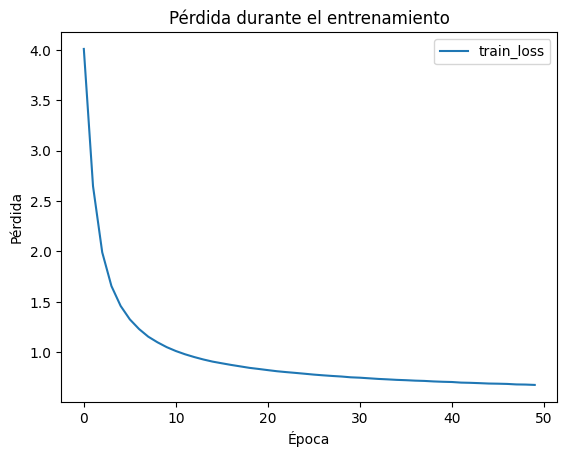

In [17]:
plt.plot(history_model.history['loss'], label='train_loss')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

#### Podemos ver que ahora al final se empezaba a estabilizar 

### Guardamos los pesos

In [25]:
model.save_weights(filename+"/modelo_pesos_GT.h5")

### Función de traducción

In [19]:
def translate(sentence):
  sentence_tokens = [tokens + ["<END>", "<PAD>"] for tokens in [sentence.split(" ")]] #Agregamos el relleno y el token del final
  tr_input = [list(map(lambda x: source_token_dict[x], tokens)) for tokens in sentence_tokens][0] #Codificamos la entrada (los pasamos a nº)
  #LLamamos a la función decode de la librería
  decoded = decode(
      model,#Nuestro modelo
      tr_input,#Lo que tiene que traducir
      start_token = target_token_dict["<START>"],
      end_token = target_token_dict["<END>"],
      pad_token = target_token_dict["<PAD>"]
  )

  print('Frase original: {}'.format(sentence))
  print('Traducción: {}'.format(' '.join(map(lambda x: target_token_dict_inv[x], decoded[1:-1]))))

#### Llamamos a la función

In [36]:
translate("hola buenos dias")

1/1 [==============================] - 0s 72ms/step
Frase original: hola buenos dias
Traducción: hi good days
